In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")
colors = sns.color_palette()

# Example - Particle smoother

We will now be shifting focus to the smoothing problem. Recall from lecture that the smoothing problem is the problem of estimating the state of a system at a time $t$ given all the observations up to time $T$. Contrasting this with the filtering problem, the filtering problem is the problem of estimating the state of a system at a time $t$ given all the observations up to time $t$. So we have more information in the smoothing problem than in the filtering problem.

We will again be using the jax-based code for particle filters in a package called [dax](https://github.com/PredictiveScienceLab/dax).

In [54]:
!pip install diffrax optax blackjax seaborn toml git+https://github.com/PredictiveScienceLab/dax.git

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/PredictiveScienceLab/dax.git to /private/var/folders/cm/5m6g5c890j5cwww5cq4_ydk00000gp/T/pip-req-build-f2p5856o
  Running command git clone --filter=blob:none --quiet https://github.com/PredictiveScienceLab/dax.git /private/var/folders/cm/5m6g5c890j5cwww5cq4_ydk00000gp/T/pip-req-build-f2p5856o
  Resolved https://github.com/PredictiveScienceLab/dax.git to commit 022ce93c3ce7929adcbb750ef70d5058b34e8a4b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [55]:
import dax
import jax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import optax

jax.config.update("jax_enable_x64", True)
key = jr.PRNGKey(0)

### Duffing Oscillator

Let's revisit the Duffing Oscillator example.

$$\ddot{x} + \delta \dot{x} + \alpha x + \beta x^3 = \gamma \cos(\omega t) + \sigma \xi(t)$$

As a system of first order ODEs, this becomes:

$$
\begin{align*}
dX_1 & = X_2 \\
dX_2 & = (\gamma \cos(\omega t) - \delta v - \alpha x - \beta x^3)dt + \sigma dW_t
\end{align*}
$$

Discretized with Euler-Maruyama:

$$
\begin{align*}
X_{1,t} & = X_{1,t-\Delta t} + X_{2,t - \Delta t} \Delta t \\
X_{2,t} & = X_{2,t-\Delta t} + (\gamma \cos(\omega t - \Delta t) - \delta X_{2, t-\Delta t} - \alpha X_{1, t - \Delta t} - \beta X_{1, t - \Delta t}^3) \Delta t + \sigma \sqrt{\Delta t} Z_{t - \Delta t}
\end{align*}
$$

In the state space model, we have the following transition probabilties:

$$
p(x_t | x_{t-1}, u_t) = \mathcal{N} \left(  x_t \left| \begin{bmatrix} x_{t-1} + v_{t-1} \Delta t \\ v_{t-1} + (\gamma \cos(\omega t - \Delta t) - \delta v_{t-1} - \alpha x_{t-1} - \beta x_{t-1}^3) \Delta t \end{bmatrix} \right. , \text{diag}(\sigma_x^2, \sigma_v^2) \Delta t \right)
$$

where $u_t$ is the control input:

$$
u_t = \omega \cos(\omega ((t-1) \Delta t))
$$

Let's redefine the Duffing Oscillator.

In [56]:
# Define the right-hand side, deterministic part of the Duffing oscillator
class DuffingControl(dax.ControlFunction):

    omega: jax.Array

    def __init__(self, omega):
        self.omega = jnp.array(omega)
    
    def _eval(self, t):
        # This is to avoid training the parameter
        omega = jax.lax.stop_gradient(self.omega)
        return jnp.cos(omega * t)

# Define the stochastic differential equation
class Duffing(dax.StochasticDifferentialEquation):

    alpha: jax.Array
    beta: jax.Array
    delta: jax.Array

    gamma: jax.Array
    log_sigma_x: jax.Array
    log_sigma_v: jax.Array

    @property
    def sigma_x(self):
        return jnp.exp(self.log_sigma_x)

    @property
    def sigma_v(self):
        return jnp.exp(self.log_sigma_v)

    def __init__(self, alpha, beta, gamma, delta, sigma_x, sigma_v, u):
        super().__init__(control_function=u)
        self.alpha = jnp.array(alpha)
        self.beta = jnp.array(beta)
        self.delta = jnp.array(delta)

        self.gamma = jnp.array(gamma)
        self.log_sigma_x = jnp.log(sigma_x)
        self.log_sigma_v = jnp.log(sigma_v)
    
    def drift(self, x, u):
        # We won't train gamma
        gamma = jax.lax.stop_gradient(self.gamma)
        return jnp.array([x[1], -self.delta * x[1] - self.alpha * x[0] - self.beta * x[0] ** 3 + gamma * u])
    
    def diffusion(self, x, u):
        # We won't train sigma_x and sigma_v
        sigma_x = jax.lax.stop_gradient(self.sigma_x)
        sigma_v = jax.lax.stop_gradient(self.sigma_v)
        return jnp.array([sigma_x, sigma_v])

Define the parameters and state space model.

In [57]:
# Define the parameters
omega = 1.2
alpha = -1.0
beta = 1.0
delta = 0.3
gamma = 0.5
sigma_x = 0.01
sigma_v = 0.05
u = DuffingControl(omega)
true_sde = Duffing(alpha, beta, gamma, delta, sigma_x, sigma_v, u)

# True initial conditions
true_x0 = jnp.array([1.0, 0.0])

# Observation model
observation_function = dax.SingleStateSelector(0)
# Observation variance
s = 0.1
true_likelihood = dax.GaussianLikelihood(s, observation_function)

dt = 0.1
# Make the statespace model
x0 = dax.DiagonalGaussian(
    jnp.array([0.0, 0.0]),
    jnp.array([1.0, 1.0])
)
ssm = dax.StateSpaceModel(
    dax.DiagonalGaussian(
        jnp.array([0.0, 0.0]),
        jnp.array([1.0, 1.0])),
    dax.EulerMaruyama(true_sde, dt=dt),
    true_likelihood
)

Let's generate our data.

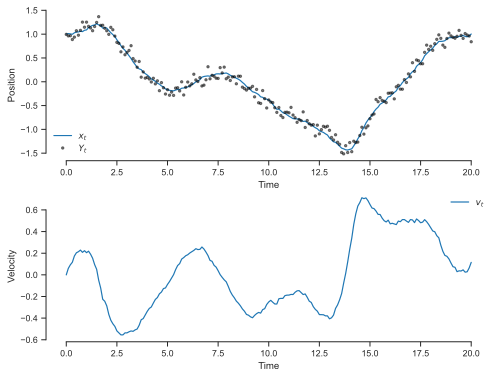

In [58]:
# Define the length of the simulation
t0 = 0.0
t1 = 20.0

# Generate synthetic data
sol = true_sde.sample_path(key, t0, t1, true_x0, dt=dt, dt0=0.05)
key, subkey = jr.split(key)
xs = sol.ys
ts = sol.ts
us = u(ts)
keys = jr.split(key, xs.shape[0])
ys = true_likelihood.sample(xs, us, keys)

# Plot the observed data
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Position plot
ax[0].plot(ts, xs[:, 0], label=r'$x_t$')
ax[0].plot(ts, ys[:, 0], 'k.', label=r'$Y_t$', alpha=0.5)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Position')
ax[0].legend(frameon=False)
sns.despine(ax=ax[0], trim=True)

# Velocity plot
ax[1].plot(ts, xs[:, 1], label=r'$v_t$')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
ax[1].legend(frameon=False)
sns.despine(ax=ax[1], trim=True)

plt.show()

And recall, we are not interested in predicting the future, but rather estimating the past, so we will not split the data into training and testing sets. Let's look at the filtering results first.

Filtering...


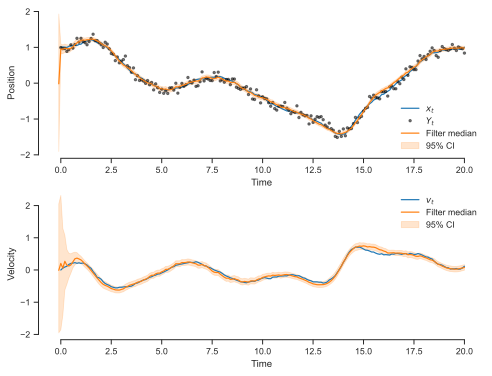

In [59]:
# Define what we will use for filtering
ts_w_init = jnp.concatenate([jnp.array([ts[0] - dt]), ts])
us_all = us
ys_all = ys

# Ready to do the filtering
num_particles = 10_000

print('Filtering...')
filter = dax.BootstrapFilter(num_particles=num_particles)
key, subkey = jr.split(key)
pas, log_L = filter.filter(ssm, us_all, ys_all, subkey)

key, subkey = jr.split(key)
lower, median, upper = pas.get_credible_interval(subkey)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Position plot
ax[0].plot(ts, xs[:, 0], label=r'$x_t$')
ax[0].plot(ts, ys_all[:, 0], 'k.', label=r'$Y_t$', alpha=0.5)
ax[0].plot(ts_w_init, median[:, 0], label='Filter median')
ax[0].fill_between(ts_w_init, lower[:, 0], upper[:, 0], alpha=0.2, color=colors[1], label='95% CI')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Position')
ax[0].legend(frameon=False)
sns.despine(ax=ax[0], trim=True)

# Velocity plot
ax[1].plot(ts, xs[:, 1], label=r'$v_t$')
ax[1].plot(ts_w_init, median[:, 1], label='Filter median')
ax[1].fill_between(ts_w_init, lower[:, 1], upper[:, 1], alpha=0.2, color=colors[1], label='95% CI')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
ax[1].legend(frameon=False)
sns.despine(ax=ax[1], trim=True)
plt.show()


Now we are going to run the smoother.

Smoothing...


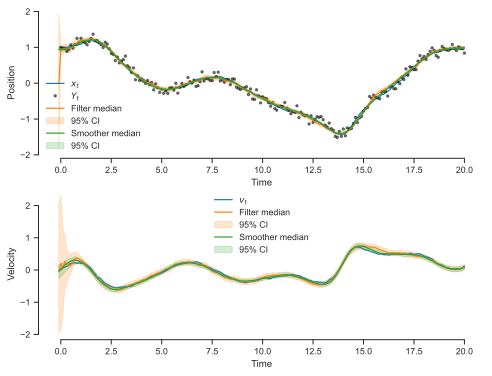

In [60]:
print('Smoothing...')
smoothing_samples = 1000
smoother = dax.BootstrapSmoother(smoothing_samples)
key, subkey = jr.split(key)
trajectories = smoother.smooth(ssm, pas, us_all, ys_all, subkey)
smoothed_lower, smoothed_median, smoothed_upper = trajectories.get_credible_interval()

# Plot the results against the true value and the filtered value
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Position plot
ax[0].plot(ts, xs[:, 0], label=r'$x_t$')
ax[0].plot(ts, ys_all[:, 0], 'k.', label=r'$Y_t$', alpha=0.5)
ax[0].plot(ts_w_init, median[:, 0], label='Filter median')
ax[0].fill_between(ts_w_init, lower[:, 0], upper[:, 0], alpha=0.2, color=colors[1], label='95% CI')
ax[0].plot(ts_w_init, smoothed_median[:, 0], label='Smoother median')
ax[0].fill_between(ts_w_init, smoothed_lower[:, 0], smoothed_upper[:, 0], alpha=0.2, color=colors[2], label='95% CI')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Position')
ax[0].legend(frameon=False)
sns.despine(ax=ax[0], trim=True)

# Velocity plot
ax[1].plot(ts, xs[:, 1], label=r'$v_t$')
ax[1].plot(ts_w_init, median[:, 1], label='Filter median')
ax[1].fill_between(ts_w_init, lower[:, 1], upper[:, 1], alpha=0.2, color=colors[1], label='95% CI')
ax[1].plot(ts_w_init, smoothed_median[:, 1], label='Smoother median')
ax[1].fill_between(ts_w_init, smoothed_lower[:, 1], smoothed_upper[:, 1], alpha=0.2, color=colors[2], label='95% CI')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
ax[1].legend(frameon=False)
sns.despine(ax=ax[1], trim=True)
plt.show()


We can see the smoother is able to estimate the past states better than the filter. Particularly, the smoother is able to estimate the states at the beginning of the time series better than the filter because it has the benefit of using the upcoming observations. Let's take a closer look at that starting segment.

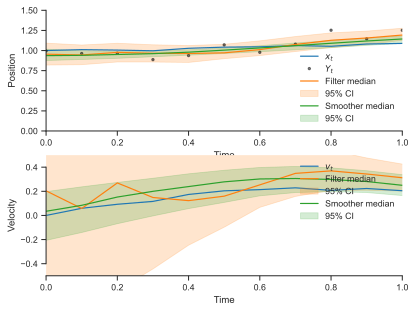

In [61]:
# Plot the results against the true value and the filtered value
fig, ax = plt.subplots(2, 1)

# Position plot
ax[0].plot(ts, xs[:, 0], label=r'$x_t$')
ax[0].plot(ts, ys_all[:, 0], 'k.', label=r'$Y_t$', alpha=0.5)
ax[0].plot(ts_w_init, median[:, 0], label='Filter median')
ax[0].fill_between(ts_w_init, lower[:, 0], upper[:, 0], alpha=0.2, color=colors[1], label='95% CI')
ax[0].plot(ts_w_init, smoothed_median[:, 0], label='Smoother median')
ax[0].fill_between(ts_w_init, smoothed_lower[:, 0], smoothed_upper[:, 0], alpha=0.2, color=colors[2], label='95% CI')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Position')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1.5])
ax[0].legend(frameon=False)
sns.despine(ax=ax[0], trim=True)

# Velocity plot
ax[1].plot(ts, xs[:, 1], label=r'$v_t$')
ax[1].plot(ts_w_init, median[:, 1], label='Filter median')
ax[1].fill_between(ts_w_init, lower[:, 1], upper[:, 1], alpha=0.2, color=colors[1], label='95% CI')
ax[1].plot(ts_w_init, smoothed_median[:, 1], label='Smoother median')
ax[1].fill_between(ts_w_init, smoothed_lower[:, 1], smoothed_upper[:, 1], alpha=0.2, color=colors[2], label='95% CI')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([-0.5, 0.5])
ax[1].legend(frameon=False, loc='upper right')
sns.despine(ax=ax[1], trim=True)
plt.show()

You can see how at the initial few time steps for the velocity state, the smoother performs much better than the  filter. The filter is still assimilating data and trying to approach the true state, but the smoother has the advantage of seeing the entire span of the position state, and therefore can estimate the hidden velocity state much better. Let's try to get a better sense of the performance from the phase plot.

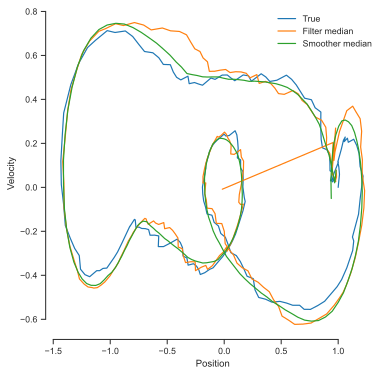

In [62]:
# Create the phase plot from the filtered and smoothed values against the true value
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# True values
ax.plot(xs[:, 0], xs[:, 1], label='True')
# Filtered
ax.plot(median[:, 0], median[:, 1], label='Filter median')
# Smoothed
ax.plot(smoothed_median[:, 0], smoothed_median[:, 1], label='Smoother median')
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.legend(frameon=False)
sns.despine(ax=ax, trim=True)
plt.show()

We can verify from the phase portrait that the smoother is able to estimate the past states better than the filter. If you increase the observation variance, you will see this effect become more pronounced.

Also note, the estimation lives up to its name, smoothing out the noise in the data.